In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_rules_of_tree_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, settings

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
def get_predicted_rules(indices=None):
    indices = np.where(y_true)[0] if indices is None else indices
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    return pd.Series(pred_rule_nos, index=indices)

# Explanations

In [5]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 6min 21s, sys: 3.38 s, total: 6min 25s
Wall time: 6min 54s


## $(0,1)$

In [62]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [63]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [64]:
settings['contour_legend_location'] = 'lower left'
settings['scatter_legend_location'] = 'upper right'

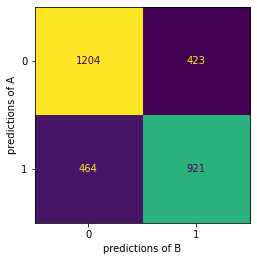

In [65]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/running-diro2c-cf-01.pdf', bbox_inches='tight', pad_inches=0)

In [66]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 17.9 ms, sys: 9.03 ms, total: 27 ms
Wall time: 51.2 ms


3

In [67]:
trees[-1].get_depth()

4

In [68]:
trees[-1].tree_.node_count

13

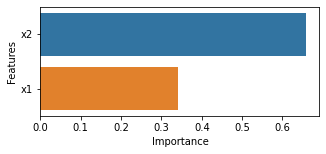

In [69]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

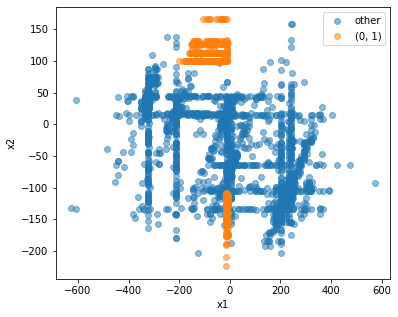

In [70]:
plot_diro2c_2d(explanation, 'x1', 'x2', class_names=class_names)
plt.savefig('figures/running-diro2c-generated-data-01.pdf', bbox_inches='tight', pad_inches=0)

### 2 Leafs

In [71]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.032165196189669086, 1, 2)

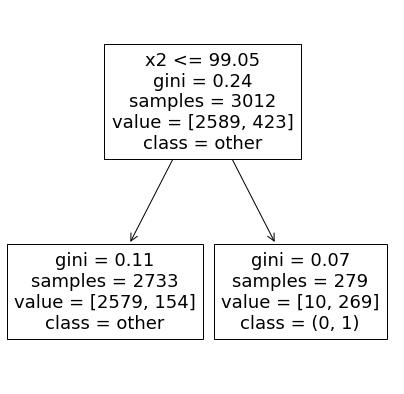

In [72]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [73]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x2 > 99.1 => (0, 1) [10, 269]


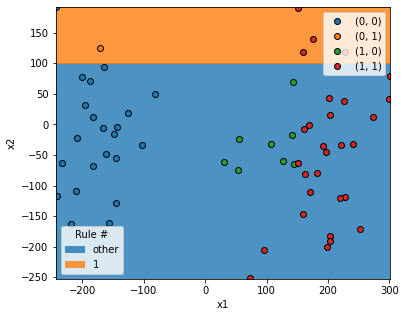

In [74]:
plot_rules_of_tree_for_class(tree, tree.classes_, tree.classes_[1:2], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 5 Leafs

In [75]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0032010548011062083, 4, 5)

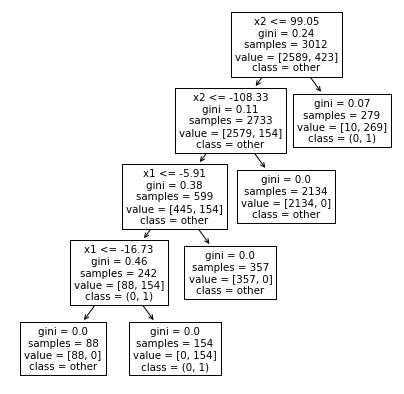

In [76]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [77]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x2 > 99.1 => (0, 1) [10, 269]
2. -16.7 < x1 <= -5.9 and x2 <= -108.3 => (0, 1) [0, 154]


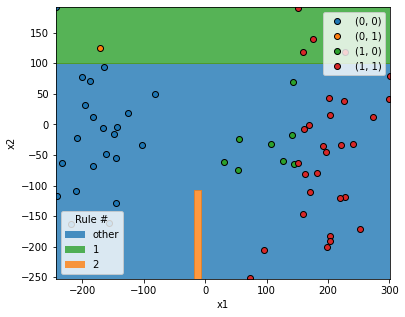

In [78]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 7 Leafs

In [79]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 4, 7)

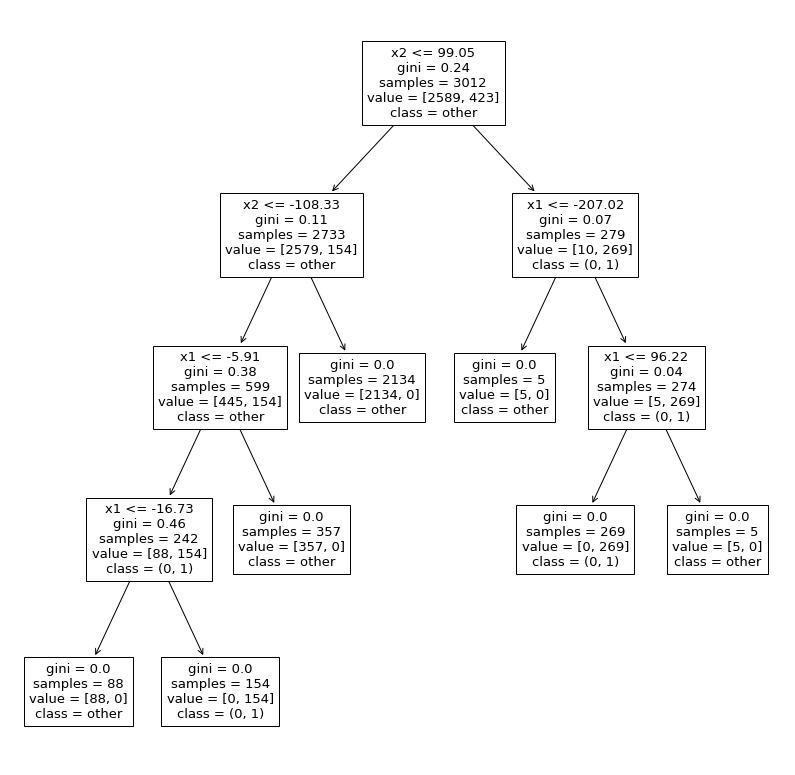

In [80]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [81]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -207.0 < x1 <= 96.2 and x2 > 99.1 => (0, 1) [0, 269]
2. -16.7 < x1 <= -5.9 and x2 <= -108.3 => (0, 1) [0, 154]


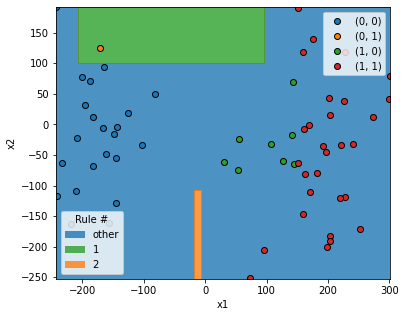

In [82]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)
plt.savefig('figures/running-diro2c-final-01.pdf', bbox_inches='tight', pad_inches=0)

In [83]:
pred_rules = get_predicted_rules()
indices_not_explained = pred_rules.index[pd.isna(pred_rules)].tolist()
indices_not_explained

[]

## $(1,0)$

In [85]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [86]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

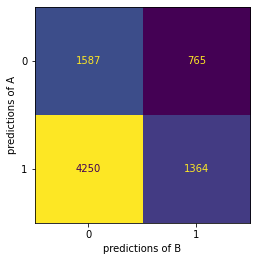

In [87]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/running-diro2c-cf-10.pdf', bbox_inches='tight', pad_inches=0)

In [88]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 35.6 ms, sys: 3.85 ms, total: 39.4 ms
Wall time: 65.1 ms


4

In [35]:
trees[-1].get_depth()

4

In [89]:
trees[-1].tree_.node_count

9

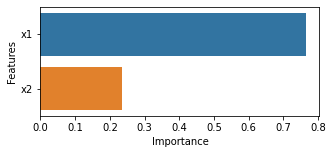

In [36]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order)

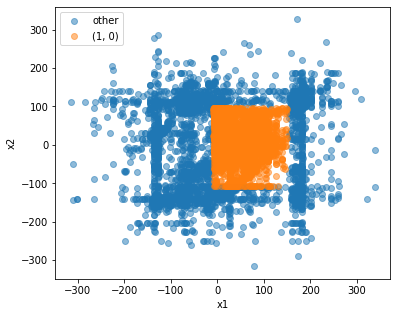

In [37]:
plot_diro2c_2d(explanation, 'x1', 'x2', class_names=class_names)
plt.savefig('figures/running-diro2c-generated-data-10.pdf', bbox_inches='tight', pad_inches=0)

### 2 Leafs

In [38]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.1427293550844675, 1, 2)

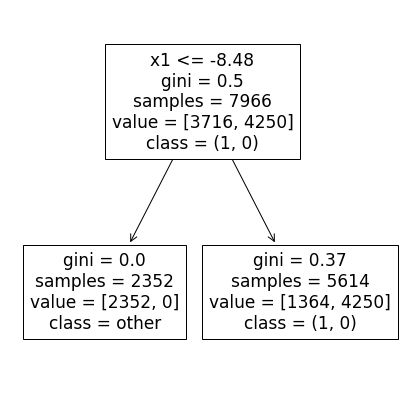

In [39]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [40]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. x1 > -8.5 => (0, 1) [1364, 4250]


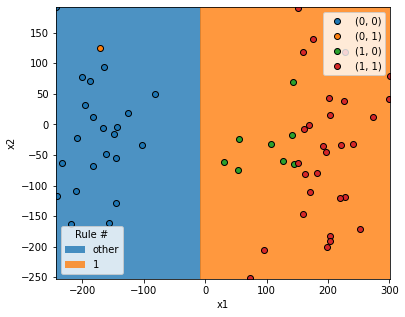

In [41]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 3 Leafs

In [42]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.08061423627602936, 2, 3)

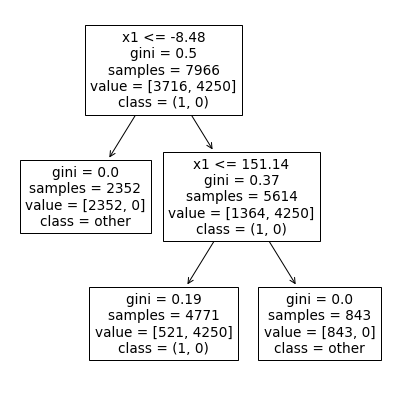

In [43]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [44]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -8.5 < x1 <= 151.1 => (0, 1) [521, 4250]


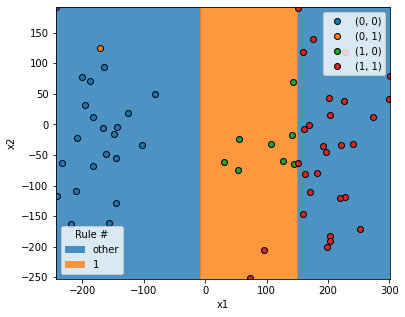

In [45]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 4 Leafs

In [46]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.035907495441346526, 3, 4)

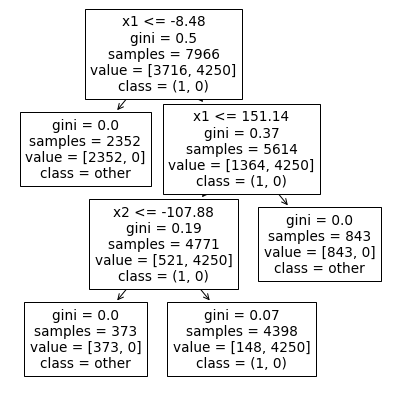

In [47]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [48]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -8.5 < x1 <= 151.1 and x2 > -107.9 => (0, 1) [148, 4250]


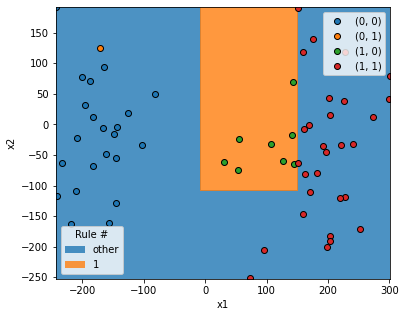

In [49]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)

### 5 Leafs

In [50]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 4, 5)

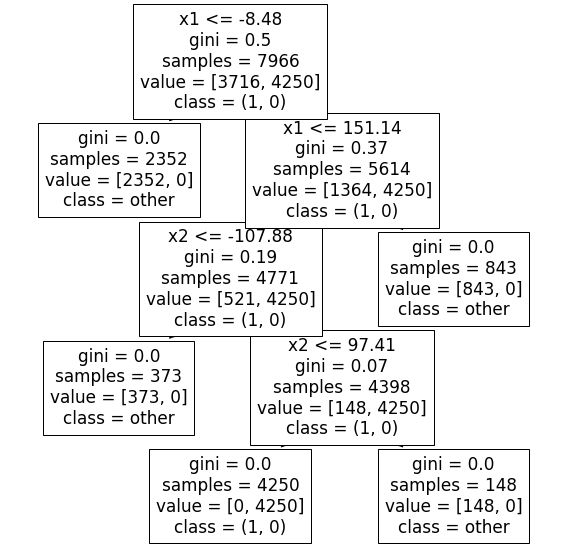

In [51]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(10, 10))

In [52]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions)
print_rules(rules, class_occurences, comparer.class_names, labels)

1. -8.5 < x1 <= 151.1 and -107.9 < x2 <= 97.4 => (0, 1) [0, 4250]


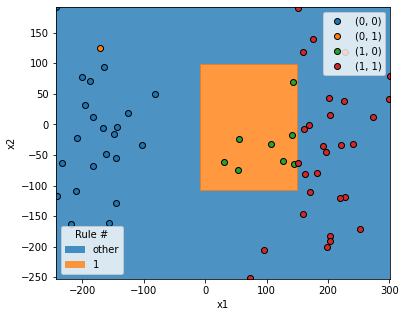

In [53]:
plot_rules_of_tree_for_class(tree, tree.classes_, [tree.classes_[1]], X, mclass_diff, comparer.class_names, feature_names, rule_order)
plt.savefig('figures/running-diro2c-final-10.pdf', bbox_inches='tight', pad_inches=0)

In [54]:
pred_rules = get_predicted_rules()
indices_not_explained = pred_rules.index[pd.isna(pred_rules)].tolist()
indices_not_explained

[]

# Evaluation

In [6]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [7]:
explanations_per_class = {}
for class_name in comparer.class_names:
    with open(f'explanations/diro2c.{class_name}.pickle', 'rb') as f:
        explanations_per_class[class_name] = pickle.load(f)

In [8]:
from diro2c_wrapper import get_surrogate_tree
dict([(class_name, get_surrogate_tree(explanation).get_depth()) for class_name, explanation in explanations_per_class.items()])

{'(0, 0)': 4, '(0, 1)': 4, '(1, 0)': 4, '(1, 1)': 5}

In [9]:
metrics = eval_diro2c(explanations_per_class, X_test, y_test, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.860346,0.994815,0.922707,4050.0,"(0, 0)",2.0,0.040361,1.0,1.0
1,0.990844,0.988642,0.989742,4050.0,"(0, 0)",3.0,0.013864,1.0,2.0
1,0.990896,0.994321,0.992605,4050.0,"(0, 0)",4.0,0.002270,2.0,4.0
1,0.994321,0.994321,0.994321,4050.0,"(0, 0)",6.0,0.000000,3.0,8.0
1,0.449010,0.925870,0.604743,661.0,"(0, 1)",2.0,0.032165,1.0,1.0
1,0.458392,0.983359,0.625301,661.0,"(0, 1)",5.0,0.003201,2.0,4.0
1,0.557940,0.983359,0.711939,661.0,"(0, 1)",7.0,0.000000,2.0,6.0
1,0.615894,0.998773,0.761938,3259.0,"(1, 0)",2.0,0.142729,1.0,1.0
1,0.700753,0.998773,0.823634,3259.0,"(1, 0)",3.0,0.080614,1.0,2.0
1,0.828833,0.998466,0.905776,3259.0,"(1, 0)",4.0,0.035907,1.0,3.0


<AxesSubplot:xlabel='Constraints', ylabel='F1 Score'>

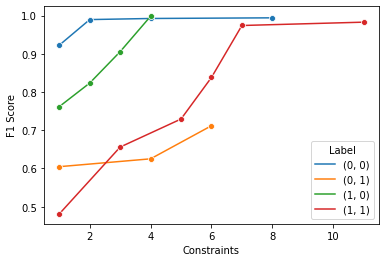

In [13]:
sns.lineplot(data=metrics, x='Constraints', y='F1 Score', hue='Label', marker='o')

In [12]:
with open('data/fidelity-diro2c.pickle', 'wb') as f:
    pickle.dump(metrics, f)

In [60]:
metrics.query('Label == "(0, 1)" and Leafs == 7')

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.55794,0.983359,0.711939,661.0,"(0, 1)",7.0,0.0,2.0,6.0


In [61]:
metrics.query('Label == "(1, 0)" and Leafs == 5')

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.998772,0.998159,0.998465,3259.0,"(1, 0)",5.0,0.0,1.0,4.0


# Additional Material

In [55]:
focus_class = '(0, 1)'
tree = get_pruned_trees(explanations_per_class[focus_class])[-1]

In [57]:
constraints, rules, class_occurences, labels, rule_order =\
    extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)

In [58]:
for rule, label in zip(rules, labels):
    print(f'\item if ${rule}$, then ${focus_class}$')

\item if $-207.0 < \mathit{x_1} \leq 96.2 \land \mathit{x_2} > 99.1$, then $(0, 1)$
\item if $-16.7 < \mathit{x_1} \leq -5.9 \land \mathit{x_2} \leq -108.3$, then $(0, 1)$


In [59]:
constraints[0] - [[-203.77635193, -8.54483223], [97.53022003, np.nan]]

array([[ -3.23979187, 104.76637888],
       [  1.51991272,          nan]])

In [60]:
constraints[1] - [[-16.3683548, -8.54483223], [np.nan, -108.15950394]]

array([[-0.36061954,  2.63797629],
       [        nan, -0.17192077]])

In [61]:
focus_class = '(1, 0)'
tree = get_pruned_trees(explanations_per_class[focus_class])[-1]

In [62]:
constraints, rules, class_occurences, labels, rule_order =\
    extract_rules(tree, feature_names, comparer.difference_classes, precisions=feature_precisions, latex=True)

In [63]:
for rule, label in zip(rules, labels):
    print(f'\item if ${rule}$, then ${focus_class}$')

\item if $-8.5 < \mathit{x_1} \leq 151.1 \land -107.9 < \mathit{x_2} \leq 97.4$, then $(1, 0)$


In [64]:
constraints[0] - [[-8.54483223, 150.74215698], [-108.15950394, 97.53022003]]

array([[ 0.06875372,  0.399086  ],
       [ 0.27607727, -0.11930084]])